In [1]:
%cd ../gendist/experiments
%load_ext autoreload
%autoreload 2

/home/gerardoduran/documents/shift-happens/gendist/experiments


In [164]:
import re
import os
import jax
import optax
import gendist
import pickle
import torchvision
import jax.numpy as jnp
import numpy as np
import mnist_rotation_meta as metaexp
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from jax.flatten_util import ravel_pytree

In [140]:
import os
from loguru import logger
from datetime import datetime

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
data_model = gendist.models.LeNet5(10)

In [8]:
key = jax.random.PRNGKey(314)
params = meta_model.init(key, jnp.ones((1, 784)))

In [10]:
ravel_pytree(params)[0].shape

(61706,)

In [160]:
path_experiment = os.path.join("..", "..", "outputs", "2203251250")
filename_data_model = os.path.join(path_experiment, "output", "data-model-result.pkl")
filename_meta_model = os.path.join(path_experiment, "output", "meta-model-result.pkl")

In [25]:
output = metaexp.load_train_combo(filename_data_model)
target_params = output["params"]
list_configs = output["configs"]
fn_reconstruct_params = output["fn_reconstruct"]

In [27]:
key = jax.random.PRNGKey(314)
key, key_subset = jax.random.split(key)

In [39]:
degrees = np.linspace(0, 360, n_configs)
list_configs = [{"angle": angle.item()} for angle in degrees]

In [26]:
n_components = 50
n_classes = 10
n_train_subset = 6_000
n_configs = len(list_configs)

In [44]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
X_train = np.array(mnist_train.data) / 255
X_train = metaexp.configure_covariates(key_subset, metaexp.processing_class, X_train, list_configs, n_train_subset)

n_train, *elem_dims = X_train.shape

tcmalloc: large alloc 5644804096 bytes == 0x563c7bd4a000 @  0x7fa2b4c0c680 0x7fa2b4c2d824 0x7fa2933581ed 0x7fa293358267 0x7fa29339ac1b 0x7fa29339aed8 0x7fa29344c177 0x7fa29344ddec 0x7fa293593652 0x563bc7994e88 0x563bc7b165d8 0x7fa293454ff7 0x563bc7a82520 0x563bc7abd568 0x563bc7a778c3 0x563bc79ef1ca 0x563bc7a76b32 0x563bc7b26ddc 0x563bc7a77b5b 0x563bc7b5c8fe 0x563bc7a55581 0x563bc79ef3be 0x563bc7a67d34 0x563bc7ac13ff 0x563bc7a67d34 0x563bc7ac13ff 0x563bc7a67d34 0x563bc7a710a3 0x563bc79ef1a4 0x563bc7a778c3 0x563bc79ef3be
tcmalloc: large alloc 2822406144 bytes == 0x563e83d40000 @  0x7fa2b4c0c680 0x7fa2b4c2d824 0x7fa2933581ed 0x7fa293358267 0x7fa29339ac1b 0x7fa293437b5e 0x7fa29343837a 0x7fa2934385ae 0x563bc7a36e64 0x563bc7a307e4 0x7fa293387a74 0x563bc7a36e88 0x563bc7a30e4f 0x563bc7abc937 0x563bc7a76b32 0x563bc7a77697 0x563bc79eef00 0x563bc7a778c3 0x563bc79ef1a4 0x563bc7a76b32 0x563bc7a77697 0x563bc7a6760a 0x563bc7a679d5 0x563bc7a30e4f 0x563bc7abc937 0x563bc7a778c3 0x563bc79ef1ca 0x563bc7a7

In [141]:
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)
X_test = np.array(mnist_test.data) / 255
y_test = np.array(mnist_test.targets)

In [150]:
X_test_subset = X_test

In [131]:
pca = PCA(n_components=n_components)
projected_params = pca.fit_transform(target_params)[None, ...]

In [136]:
alpha = 0.0005
n_epochs = 300
batch_size = 2000
tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_multi_output_loss_func
meta_model = gendist.models.MLPWeightsV1(n_components)
trainer = gendist.training.TrainingMeta(meta_model, lossfn, tx)

meta_output = trainer.fit(key, X_train, projected_params, n_epochs, batch_size)

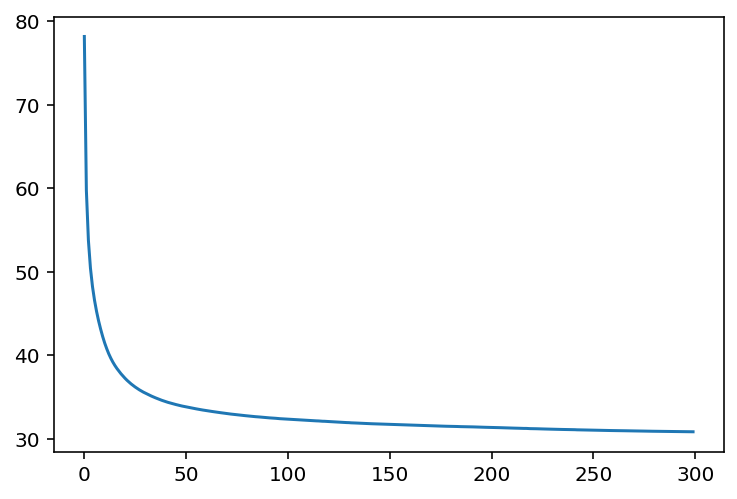

In [156]:
plt.plot(meta_output["losses"])

In [165]:
with open(filename_meta_model, "wb") as f:
    pickle.dump(meta_output, f)

## Testing the model

In [170]:
def test_meta_model(ixs, X_test, fn_processing, configurations, meta_model,
                    data_model, meta_model_params, fn_reconstruct, projector,
                    logger):
    acc_configs_learned = []
    for config in configurations:
        acc_dict = {}
        for ix in ixs:
            yhat_test = metaexp.predict_shifted_dataset(ix, X_test, fn_processing, config,
                                                        meta_model, meta_model_params,
                                                        data_model, projector, fn_reconstruct)
            yhat_test = yhat_test.argmax(axis=1)
            accuracy_learned = (yhat_test == y_test).mean().item()
            acc_dict[ix] = accuracy_learned
        acc_configs_learned.append(acc_dict)
        
        angle = config["angle"]
        logger_row = "|".join([format(v, "0.2%") for v in acc_dict.values()])
        logger_row = f"{angle=:0.4f} | " + logger_row 

        logger.info(logger_row)
    
    return pd.DataFrame(acc_configs_learned)


def load_logs(path, columns):
    with open(path, "r") as f:
        logs = f.read()

    regexp_angle = re.compile(fr"angle=([0-9\.]+)")
    regexp_acc = re.compile(r"([0-9\.]+)%")
    rows = []
    for line in logs.split("\n")[:-1]:
        accuracies = regexp_acc.findall(line)
        angle, *_ = regexp_angle.findall(line)

        row_data = {column: float(val) / 100 for column, val in zip(columns,  accuracies)}
        row_data["angle"] = float(angle)

        rows.append(row_data)
    
    return pd.DataFrame(rows)

In [172]:
logger.remove()
now_str = datetime.now().strftime("%Y%m%d%H%M")
file_log = f"trench_test_{now_str}.log"

path_logger = os.path.join(path_experiment, "logs", file_log)
logger.add(path_logger, rotation="5mb")
print(file_log)

trench_test_202203261226.log


In [173]:
acc_full = test_meta_model(ixs, X_test, metaexp.processing_class, list_configs, meta_model,
                           data_model, meta_output["params"], fn_reconstruct_params, pca, logger)

https://symbolize.stripped_domain/r/?trace=7fa2b4a80a65,7fa2b4a823bf&map= 
*** SIGTERM received by PID 377109 (TID 377109) on cpu 32 from PID 59373; stack trace: ***
PC: @     0x7fa2b4a80a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7fa2a42e87fa        992  (unknown)
    @     0x7fa2b4a823c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=7fa2b4a80a65,7fa2a42e87f9,7fa2b4a823bf&map=7a511a57244151c993b16b37978e7ed7:7fa295910000-7fa2a4652d50 
E0326 12:27:17.344022  377109 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0326 12:27:17.372580  377109 process_state.cc:770] RAW: Raising signal 15 with default behavior
https://symbolize.stripped_domain/r/?trace=563bc7a77a99,7fa2b4a823bf&map=https://symbolize.stripped_domain/r/?trace= 
*** SIGTERM received by PID 379701 (TID 379701) on cpu 56 from PID 59373; stack trace: ***
563bc7a77ac1,7fa2b4a823bf&map= 
*** SIGTERM received by PID 379792 (TID 379792) on cpu 42 

https://symbolize.stripped_domain/r/?trace=563bc7a779fb,7fa2b4a823bf&map= 
*** SIGTERM received by PID 409219 (TID 409219) on cpu 29 from PID 59373; stack trace: ***
PC: @     0x563bc7a779fb  (unknown)  _PyFunction_Vectorcall
    @     0x7fa2a42e87fa        992  (unknown)
    @     0x7fa2b4a823c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=563bc7a779fb,7fa2a42e87f9,7fa2b4a823bf&map=7a511a57244151c993b16b37978e7ed7:7fa295910000-7fa2a4652d50 
E0326 13:01:33.937103  409219 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0326 13:01:33.951489  409219 process_state.cc:770] RAW: Raising signal 15 with default behavior
https://symbolize.stripped_domain/r/?trace=7fa2b4a80a65,7fa2b4a823bf&map= 
*** SIGTERM received by PID 411399 (TID 411399) on cpu 95 from PID 59373; stack trace: ***
PC: @     0x7fa2b4a80a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7fa2a42e87fa        992  (unknown)
    @     0x7fa2b4a823c0  

<AxesSubplot:>

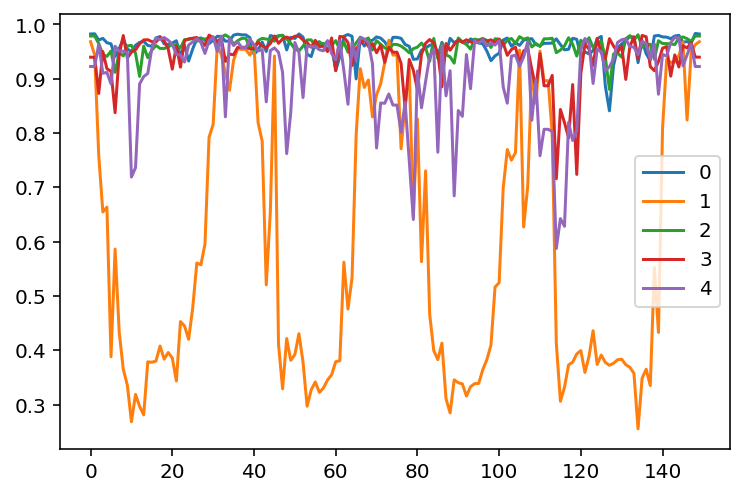

In [97]:
pd.DataFrame(accuracy_configs_learned).plot()

## Model subset test

In [177]:
target_params_sub = target_params[::3]
pca_sub = PCA(n_components=n_components)
projected_params_sub = pca_sub.fit_transform(target_params_sub)[None, ...]

In [180]:
alpha = 0.0005
n_epochs = 300
batch_size = 2000
tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_multi_output_loss_func
meta_model = gendist.models.MLPWeightsV1(n_components)
trainer = gendist.training.TrainingMeta(meta_model, lossfn, tx)

In [184]:
X_train_sub = X_train[:, ::3, :]

In [185]:
meta_output_sub = trainer.fit(key, X_train_sub, projected_params_sub, n_epochs, batch_size)

  0%|          | 0/300 [00:00<?, ?it/s]

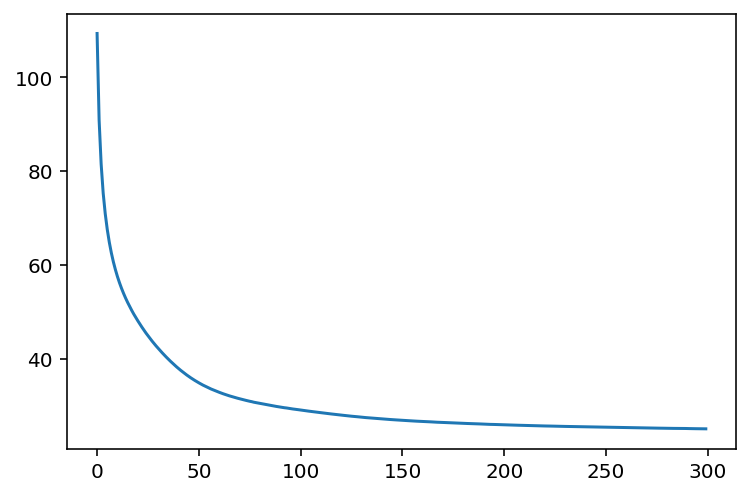

In [187]:
plt.plot(meta_output_sub["losses"])

In [189]:
logger.remove()
now_str = datetime.now().strftime("%Y%m%d%H%M")
file_log = f"trench_test_{now_str}.log"

path_logger = os.path.join(path_experiment, "logs", file_log)
logger.add(path_logger, rotation="5mb")
print(file_log)

trench_test_202203261721.log


In [190]:
acc_full_sub = test_meta_model(ixs, X_test, metaexp.processing_class, list_configs, meta_model,
                           data_model, meta_output_sub["params"], fn_reconstruct_params, pca_sub, logger)

https://symbolize.stripped_domain/r/?trace=7fa2b4a80a65,7fa2b4a823bf&map= 
*** SIGTERM received by PID 470713 (TID 470713) on cpu 30 from PID 59373; stack trace: ***
PC: @     0x7fa2b4a80a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7fa2a42e87fa        992  (unknown)
    @     0x7fa2b4a823c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=7fa2b4a80a65,7fa2a42e87f9,7fa2b4a823bf&map=7a511a57244151c993b16b37978e7ed7:7fa295910000-7fa2a4652d50 
E0326 17:29:59.097990  470713 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0326 17:29:59.112711  470713 process_state.cc:770] RAW: Raising signal 15 with default behavior
https://symbolize.stripped_domain/r/?trace=7fa2b4a80a65,7fa2b4a823bf&map= 
*** SIGTERM received by PID 478257 (TID 478257) on cpu 32 from PID 59373; stack trace: ***
PC: @     0x7fa2b4a80a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7fa2a42e87fa        992  (unknown)
    @     0x7fa2b4a823c0  (

https://symbolize.stripped_domain/r/?trace=7fa2b4a80a65,7fa2b4a823bf&map= 
*** SIGTERM received by PID 518876 (TID 518876) on cpu 31 from PID 59373; stack trace: ***
PC: @     0x7fa2b4a80a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7fa2a42e87fa        992  (unknown)
    @     0x7fa2b4a823c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=7fa2b4a80a65,7fa2a42e87f9,7fa2b4a823bf&map=7a511a57244151c993b16b37978e7ed7:7fa295910000-7fa2a4652d50 
E0326 18:21:30.466884  518876 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0326 18:21:30.480649  518876 process_state.cc:770] RAW: Raising signal 15 with default behavior
https://symbolize.stripped_domain/r/?trace=7fa2b4a80a65,7fa2b4a823bf&map= 
*** SIGTERM received by PID 523341 (TID 523341) on cpu 30 from PID 59373; stack trace: ***
PC: @     0x7fa2b4a80a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7fa2a42e87fa        992  (unknown)
    @     0x7fa2b4a823c0  (

<AxesSubplot:>

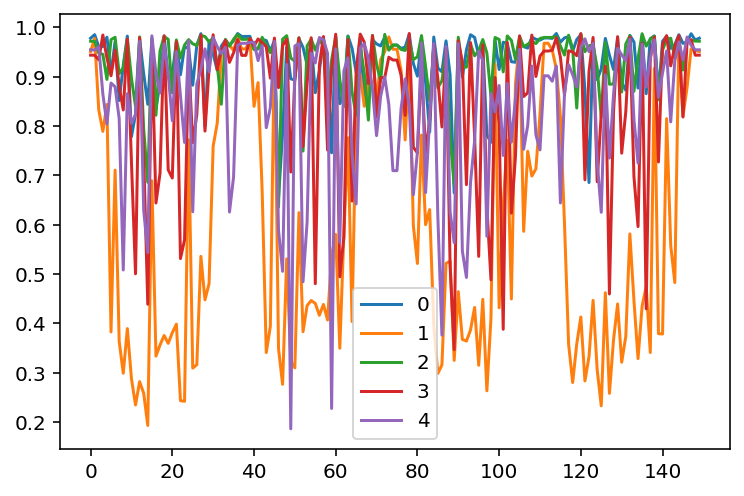

In [192]:
acc_full_sub.plot()